# Imports

In [101]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

# Read Data

In [102]:
# read data
dataFileName = ('../../_data/_processed/' + 'processed_for_viz.csv')
df = pd.read_csv(dataFileName)
print(df.columns)

Index(['name', 'rating', 'genre', 'score', 'votes', 'director', 'writer',
       'star', 'country', 'gross revenue', 'company', 'runtime',
       'release month', 'release day', 'release year', 'release month num',
       'release date', 'release quarter', 'release day of week'],
      dtype='object')


# Basic Descriptive Statistics

In [103]:
df.describe()

,score,votes,gross revenue,runtime,release day,release year,release month num,release quarter
count,7365.000000,7.365000e+03,7.365000e+03,7365.000000,7365.000000,7365.000000,7365.000000,7365.000000
mean,6.395967,9.129603e+04,7.949033e+07,107.463272,16.062729,2000.909165,6.591174,2.534012
std,0.963117,1.657359e+05,1.666292e+08,18.549380,8.550224,11.043358,3.434852,1.123712
min,1.900000,1.050000e+02,3.090000e+02,63.000000,1.000000,1980.000000,1.000000,1.000000
25%,5.800000,1.000000e+04,4.790801e+06,95.000000,9.000000,1992.000000,4.000000,2.000000
50%,6.500000,3.500000e+04,2.085152e+07,104.000000,16.000000,2001.000000,7.000000,3.000000
75%,7.100000,9.700000e+04,7.706825e+07,116.000000,23.000000,2010.000000,10.000000,4.000000
max,9.300000,2.400000e+06,2.847246e+09,366.000000,31.000000,2020.000000,12.000000,4.000000


# Train a Linear Regression Model

In [104]:
# define model variables
predictors = ['rating', 'genre', 'runtime', 'release quarter'] #'director', 'writter', 'star', 'company' are other options but they lead to
outcome = 'score'
normalize = False # normalize=true does not seem to impact the performance on this dataset
testSize = 0.4

In [105]:
# partition data
X = pd.get_dummies(df[predictors], drop_first=True)
y = df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=testSize, random_state=1)

In [106]:
# fitting a regression model
lm = LinearRegression(normalize=normalize) 
lm.fit(train_X, train_y)

# print coefficients
print('Table 6.3')
print('intercept ', lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': lm.coef_}))

# print performance measures (training data)
regressionSummary(train_y, lm.predict(train_X))

Table 6.3
intercept  0.8955238637734295
           Predictor  coefficient
0            runtime     0.019602
1    release quarter     0.011669
2           rating_G     3.090304
3       rating_NC-17     3.026509
4   rating_Not Rated     3.388148
5          rating_PG     2.895986
6       rating_PG-13     3.019209
7           rating_R     3.187357
8       rating_TV-14     3.471827
9       rating_TV-MA     3.477613
10      rating_TV-PG     4.357112
11    rating_Unrated     3.167775
12          rating_X     3.474765
13   genre_Adventure     0.215258
14   genre_Animation     1.017177
15   genre_Biography     0.702522
16      genre_Comedy     0.177261
17       genre_Crime     0.379334
18       genre_Drama     0.420462
19      genre_Family     0.774050
20     genre_Fantasy    -0.122182
21      genre_Horror    -0.149251
22       genre_Music     0.800366
23     genre_Musical     0.554706
24     genre_Mystery     0.377199
25     genre_Romance     0.415293
26      genre_Sci-Fi     0.532884
27      

# Make Predictions on Validation Data

In [107]:
# Use predict() to make predictions on a new set

lm_pred = lm.predict(valid_X)
result = pd.DataFrame({'Predicted': lm_pred, 'Actual': valid_y, 'Residual': valid_y - lm_pred})

print('Table 6.4')
print(result.head(20))


Table 6.4
      Predicted  Actual  Residual
3407   7.144504     8.5  1.355496
3716   5.827076     4.8 -1.027076
2708   6.073640     5.7 -0.373640
3359   6.855899     6.0 -0.855899
5538   6.563348     6.9  0.336652
5144   6.796080     5.2 -1.596080
7040   5.960461     6.1  0.139539
1714   5.913325     4.2 -1.713325
5131   5.713906     5.6 -0.113906
3206   6.545624     6.9  0.354376
4797   6.654794     7.5  0.845206
1139   5.909588     6.8  0.890412
6776   6.430905     6.9  0.469095
1515   6.763102     7.7  0.936898
4398   6.295986     6.6  0.304014
3508   6.655685     5.8 -0.855685
5028   6.141409     6.6  0.458591
4086   6.294028     6.3  0.005972
4768   6.230663     7.0  0.769337
951    6.109343     6.7  0.590657


# Evaluate the Performance

In [108]:
# print performance measures
regressionSummary(valid_y, lm_pred)


Regression statistics

                      Mean Error (ME) : 0.0302
       Root Mean Squared Error (RMSE) : 0.8545
            Mean Absolute Error (MAE) : 0.6614
          Mean Percentage Error (MPE) : -1.8230
Mean Absolute Percentage Error (MAPE) : 11.3640


Figure 6.1
0.7596741344195519


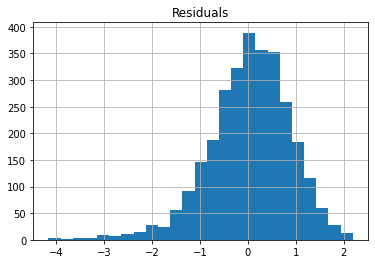

In [109]:
# plotting histogram of validation errors
bins = 25
residual_bound = .95

lm_pred = lm.predict(valid_X)
all_residuals = valid_y - lm_pred

# Determine the percentage of datapoints with a residual in [-.95, .95] = approx. 75%
print('Figure 6.1')
print(len(all_residuals[(all_residuals > -residual_bound) & (all_residuals < residual_bound)]) / len(all_residuals))

pd.DataFrame({'Residuals': all_residuals}).hist(bins=bins)
plt.show()

# Variable Selection

In [110]:
# backward elimination (stepwise)

def train_model(variables):
    model = LinearRegression(normalize=normalize) # normalize=true does not seem to impact the performance on this dataset
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

allVariables = train_X.columns
best_model_be, best_variables_be = backward_elimination(allVariables, train_model, score_model, verbose=True)

print('Table 6.6')
print(best_variables_be)

regressionSummary(valid_y, best_model_be.predict(valid_X[best_variables_be]))

Variables: runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-14, rating_TV-MA, rating_TV-PG, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Music, genre_Musical, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Sport, genre_Thriller, genre_Western
Start: score=10955.33
Step: score=10953.35, remove genre_Sport
Step: score=10951.51, remove genre_Thriller
Step: score=10949.79, remove genre_Western
Step: score=10948.23, remove genre_Musical
Step: score=10946.74, remove genre_Fantasy
Step: score=10945.67, remove genre_Music
Step: score=10944.78, remove release quarter
Step: score=10944.16, remove genre_Mystery
Step: score=10944.15, remove genre_Romance
Step: score=10944.15, remove None
Table 6.6
['runtime', 'rating_G', 'rating_NC-17', 'rating_Not Rated', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV-14', 

In [111]:
# forward selection
print('Table 6.7')

# the initial model is the constant model - this requires special handling in train_model and score_model
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression(normalize=normalize) # normalize=true does not seem to impact the performance on this dataset
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model_fs, best_variables_fs = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables_fs)

regressionSummary(valid_y, best_model_fs.predict(valid_X[best_variables_fs]))

Table 6.7
Variables: runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-14, rating_TV-MA, rating_TV-PG, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Music, genre_Musical, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Sport, genre_Thriller, genre_Western
Start: score=12171.09, constant
Step: score=11388.80, add runtime
Step: score=11264.97, add genre_Animation
Step: score=11190.81, add genre_Biography
Step: score=11101.11, add genre_Drama
Step: score=11045.88, add genre_Crime
Step: score=11018.71, add rating_R
Step: score=10992.86, add rating_Not Rated
Step: score=10972.96, add genre_Comedy
Step: score=10965.73, add genre_Adventure
Step: score=10956.98, add rating_PG
Step: score=10953.30, add genre_Family
Step: score=10950.39, add rating_TV-PG
Step: score=10947.89, add genre_Horror
Step: score=10947.86,

In [112]:
# stepwise regression
print('Table 6.8')

best_model_stepwise, best_variables_stepwise = stepwise_selection(train_X.columns, train_model, score_model, verbose=True) 
print(best_variables_stepwise)
regressionSummary(valid_y, best_model_stepwise.predict(valid_X[best_variables_stepwise]))

Table 6.8
Variables: runtime, release quarter, rating_G, rating_NC-17, rating_Not Rated, rating_PG, rating_PG-13, rating_R, rating_TV-14, rating_TV-MA, rating_TV-PG, rating_Unrated, rating_X, genre_Adventure, genre_Animation, genre_Biography, genre_Comedy, genre_Crime, genre_Drama, genre_Family, genre_Fantasy, genre_Horror, genre_Music, genre_Musical, genre_Mystery, genre_Romance, genre_Sci-Fi, genre_Sport, genre_Thriller, genre_Western
Start: score=12171.09, constant
Step: score=11388.80, add runtime
Step: score=11264.97, add genre_Animation
Step: score=11190.81, add genre_Biography
Step: score=11101.11, add genre_Drama
Step: score=11045.88, add genre_Crime
Step: score=11018.71, add rating_R
Step: score=10992.86, add rating_Not Rated
Step: score=10972.96, add genre_Comedy
Step: score=10965.73, add genre_Adventure
Step: score=10956.98, add rating_PG
Step: score=10953.30, add genre_Family
Step: score=10950.39, add rating_TV-PG
Step: score=10947.89, add genre_Horror
Step: score=10947.86,

# Use the prediction models

In [124]:
# create a movie (in this data a movie can't have more than one rating nor more than one genre)
newMovie = pd.DataFrame([{
    'runtime': 3*60,
    'release quarter': 4, # 1-4
    'rating_G': 0,
    'rating_NC-17': 0,
    'rating_Not Rated': 0,
    'rating_PG': 0,
    'rating_PG-13': 0,
    'rating_R': 1,
    'rating_TV-MA': 0,
    'rating_Unrated': 0,
    'rating_X': 0,
    'rating_TV-14': 0, 
    'rating_TV-PG': 0, 
    'genre_Adventure': 0,
    'genre_Animation': 0,
    'genre_Biography': 0,
    'genre_Comedy': 0,
    'genre_Crime': 1,
    'genre_Drama': 0,
    'genre_Family': 0,
    'genre_Fantasy': 0,
    'genre_Horror': 0,
    'genre_Mystery': 0,
    'genre_Romance': 0,
    'genre_Sci-Fi': 0,
    'genre_Thriller': 0,
    'genre_Western': 0,
    'genre_Music': 0,
    'genre_Musical': 0,
    'genre_Sport':0
}])

newMovie_thin = newMovie.loc[:, ~(newMovie == 0).any()]

# predict it's score
print(f'What score do we expect from a new movie with the following features?\n{newMovie_thin.T}\n')
print(f'{outcome} per original model (all predictors): {lm.predict(newMovie[X.columns])}')
print(f'{outcome} per backward elimination: {best_model_be.predict(newMovie[best_variables_be])}')
print(f'{outcome} per forward selection: {best_model_fs.predict(newMovie[best_variables_fs])}')
print(f'{outcome} per stepwise: {best_model_stepwise.predict(newMovie[best_variables_stepwise])}')

What score do we expect from a new movie with the following features?
                   0
runtime          120
release quarter    4
rating_R           1
genre_Comedy       1

score per original model (all predictors): [6.65903846]
score per backward elimination: [6.64336285]
score per forward selection: [6.64093371]
score per stepwise: [6.64093371]
